In [16]:
import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity import *
from low_rank_rnns import CFDTF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np

In [17]:
size = 120
noise_std = 5e-2
alpha = .2
lr = 1e-2

input_size = 3
output_size = 1

In [18]:
x_train, y_train, mask_train, cohAll_train, taskType_train, x_val, y_val, mask_val, cohAll_val, taskType_val = CFDTF.generate_checker_data(5000)


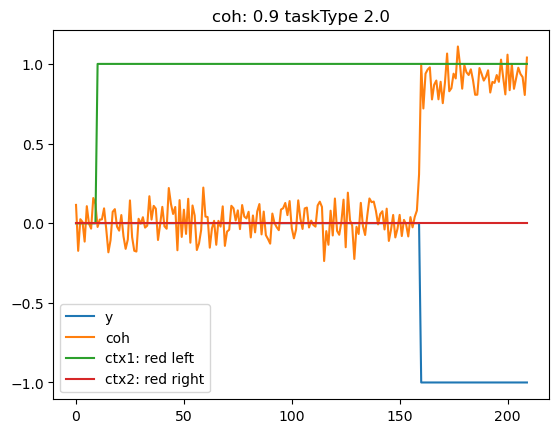

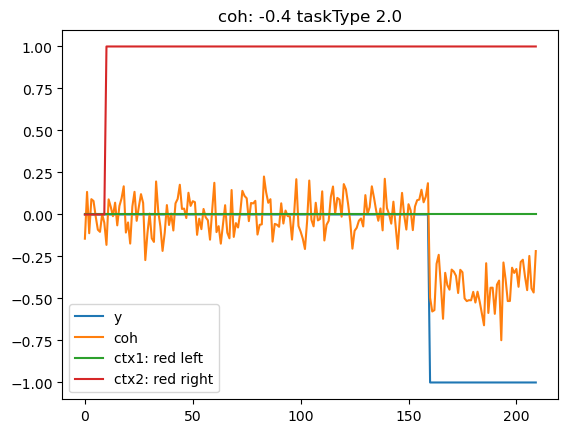

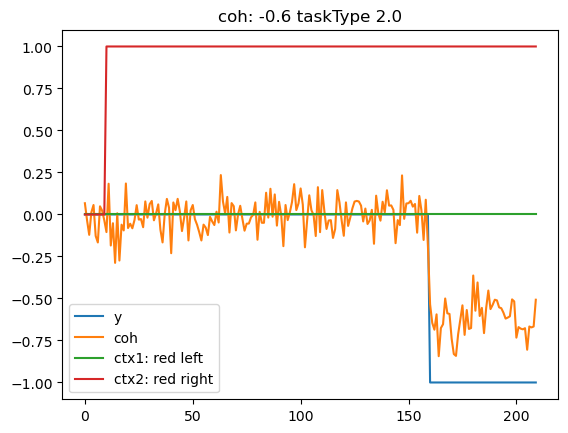

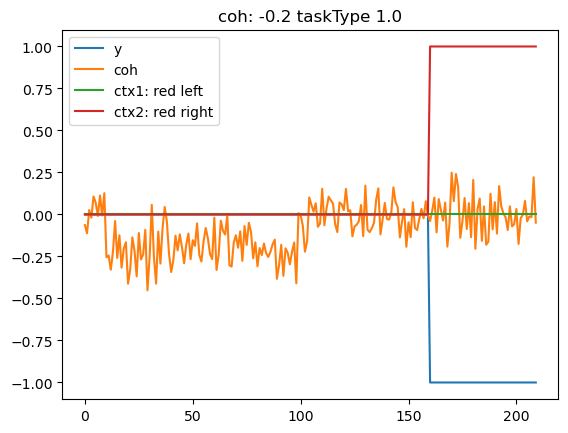

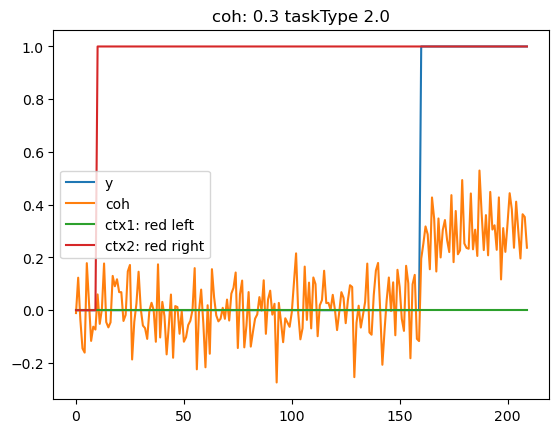

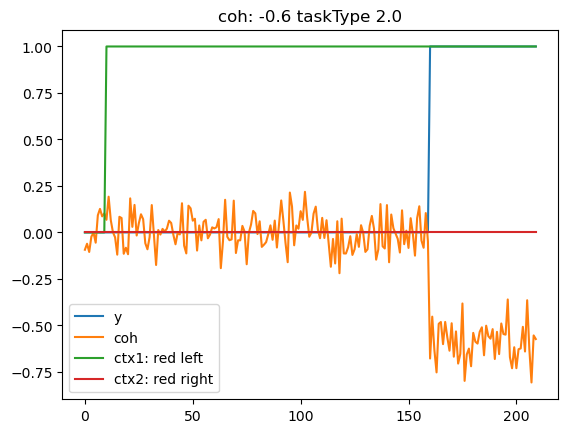

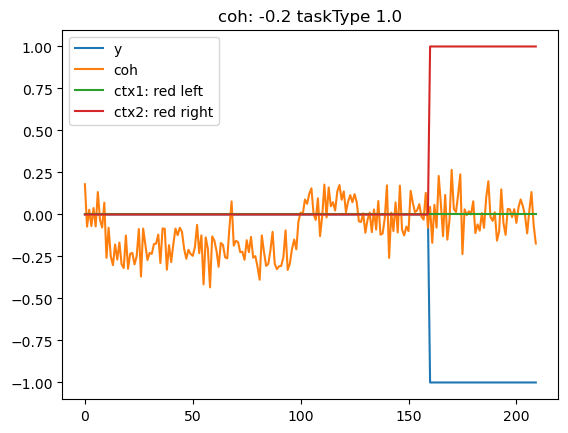

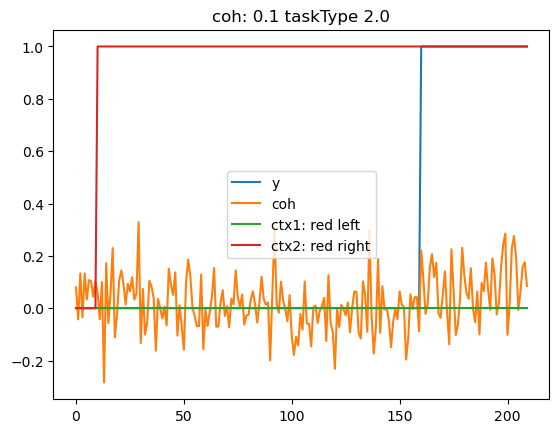

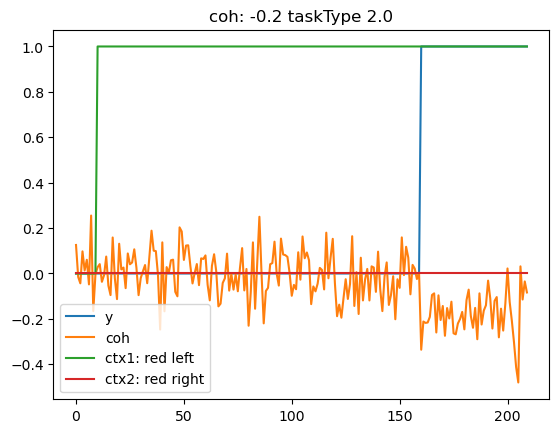

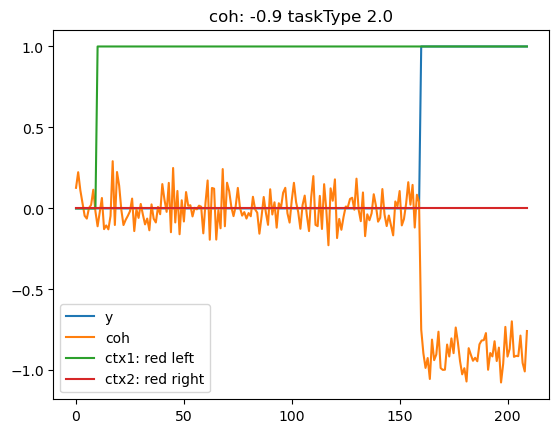

In [19]:
jkkjkjjk   

for n in range(10):
    plt.figure()
    plt.plot(y_val[n,:,:], label = 'y')
    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx1: red left')
    plt.plot(x_val[n,:,2], label = 'ctx2: red right')
    plt.title('coh: ' + str(cohAll_val[n]) + ' taskType ' + str(taskType_val[n]))
    plt.legend()
    plt.show()
    

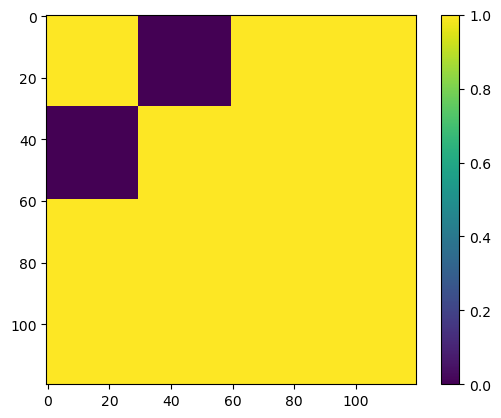

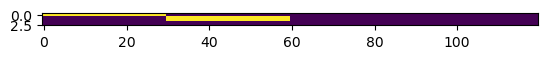

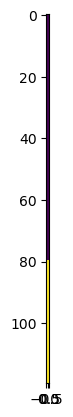

In [22]:
# modify the connectivity matrix: separate input and output 

wrec_mask = np.ones((size, size))
wrec_mask[0:30,30:60] = 0
wrec_mask[30:60,0:30] = 0
# wrec_mask[60:120,0:60] = 0

# wrec_mask[0:30,60:80] = 1
# wrec_mask[30:60,80:100] = 1

# wrec_mask[80:100,0:30] = 0
# wrec_mask[60:80,30:60] = 0

# wrec_mask[100:120,0:60] = 0


plt.figure()
plt.imshow(wrec_mask)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

wrec_mask1 = torch.tensor(wrec_mask)
wrec_mask1 = wrec_mask1.float()


wi_mask = np.zeros((input_size, size))
wi_mask[0,:30] = 1
wi_mask[1:2,30:60] = 1

wi_mask1 = torch.tensor(wi_mask)
wi_mask1 = wi_mask1.float()


wo_mask = np.zeros((size, output_size))
wo_mask[80:size,:] = 1
wo_mask1 = torch.tensor(wo_mask)
wo_mask1 = wo_mask1.float()

plt.figure()
plt.imshow(wi_mask)
plt.show()

plt.figure()
plt.imshow(wo_mask)
plt.show()

In [23]:
net = FullRankRNN(3, size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True, 
                  wrec_mask = wrec_mask1, wi_mask = wi_mask1, wo_mask = wo_mask1)


## train a full-rank RNN

In [24]:

# net_fr = FullRankRNN(1, hidden_size, 1, noise_std, alpha)

net.non_linearity = torch.tanh
net.out_non_linearity = torch.eye


train(net, x_train, y_train, mask_train, n_epochs=10, lr=lr / sqrt(size), batch_size=50, 
      mask_gradients = True, keep_best=True, cuda=True, early_stop=0.3)



x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)

# will only choose 1 of the 2  
# out = net.forward(x_val)
loss, acc, out, decisions, target_decisions, traj = CFDTF.test_checker(net, x_val, y_val, mask_val)

print(acc)
# torch.save(net.state_dict(), f'../models/CFDTF{size}.pt')

Training...
initial loss: 1.003
epoch 0:  loss=0.745  (took 9.31 s) *
epoch 1:  loss=0.336  (took 9.15 s) *
epoch 2:  loss=0.268  (took 9.39 s) *
0.9879999756813049


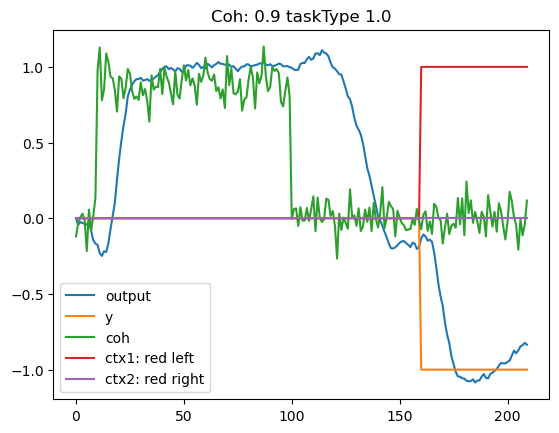

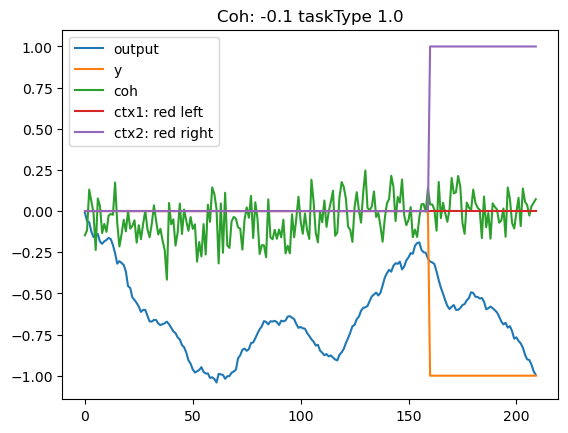

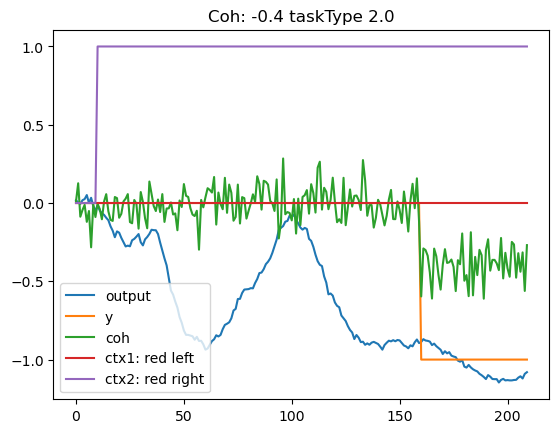

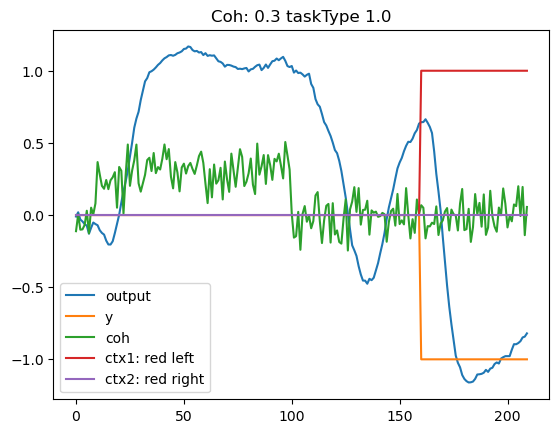

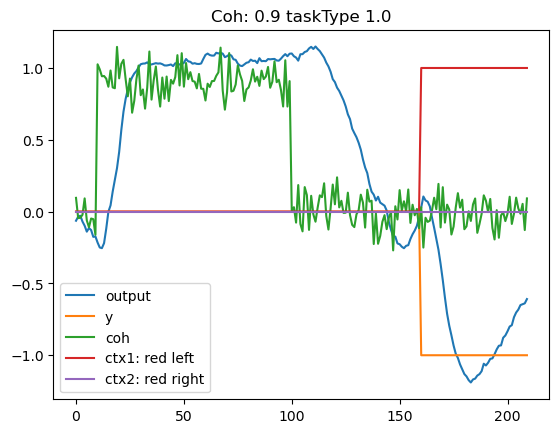

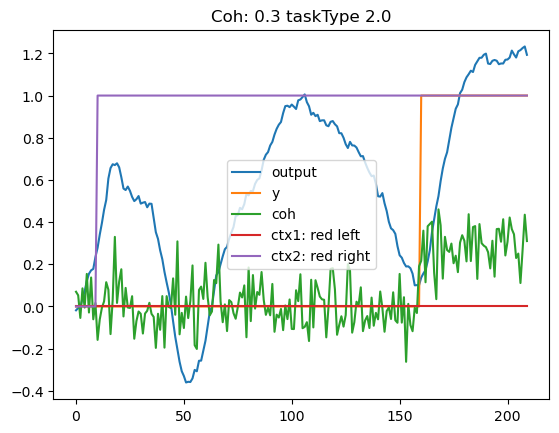

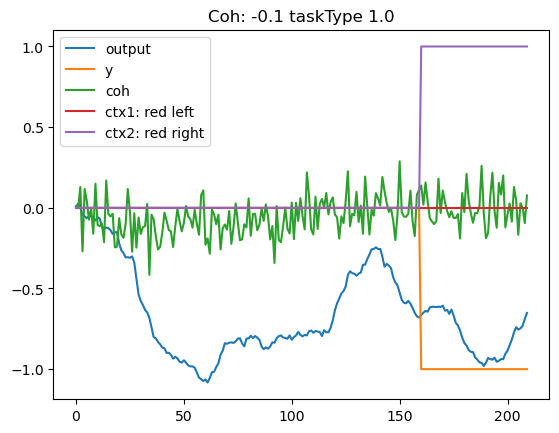

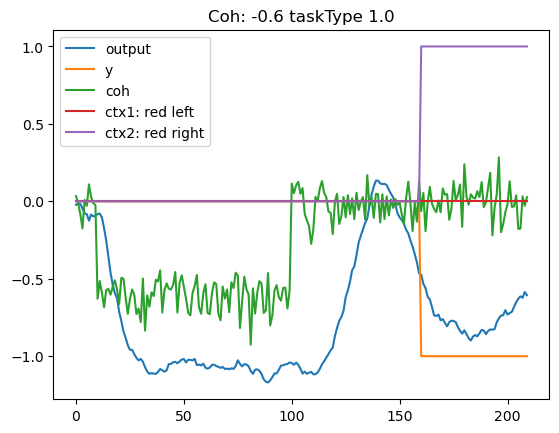

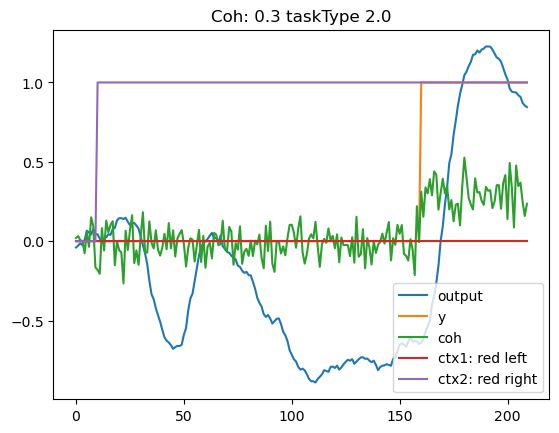

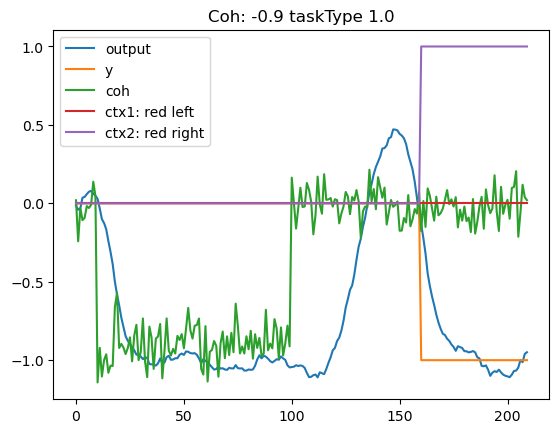

In [25]:
for n in range(10,20):
    plt.figure()
    aa = out.detach().numpy()
    plt.plot(aa[n,:,:], label = 'output')
    plt.plot(y_val[n,:,:], label = 'y')

    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx1: red left')
    plt.plot(x_val[n,:,2], label = 'ctx2: red right')
    plt.title('Coh: ' + str(cohAll_val[n]) + ' taskType ' + str(taskType_val[n]))
    plt.legend()
    plt.show()

# plot psth

In [26]:
decisions1 = decisions.detach().numpy()
out1 = out.detach().numpy()
x_val1 = x_val.detach().numpy()
traj1 = traj.detach().numpy()

In [27]:
cfdDecision = decisions1[taskType_val == 1]
tfDecision = decisions1[taskType_val == 2]
cfdInputs = x_val1[taskType_val == 1]
tfInputs = x_val1[taskType_val == 2]
cfdOut = out1[taskType_val == 1]
tfOut = out1[taskType_val == 2]

cfdTraj = traj1[taskType_val == 1,:,:]
tfTraj = traj1[taskType_val == 2,:,:]

cfdCoh = cohAll_val[taskType_val == 1]
tfCoh = cohAll_val[taskType_val == 2]

In [28]:
cfdRL = cfdTraj[np.logical_and(cfdDecision == -1, cfdCoh > 0),:,:]
cfdRR = cfdTraj[np.logical_and(cfdDecision == 1, cfdCoh > 0),:,:]
cfdGL = cfdTraj[np.logical_and(cfdDecision == -1, cfdCoh < 0),:,:]
cfdGR = cfdTraj[np.logical_and(cfdDecision == 1, cfdCoh < 0),:,:]

tfRL = tfTraj[np.logical_and(tfDecision == -1, tfCoh > 0),:,:]
tfRR = tfTraj[np.logical_and(tfDecision == 1, tfCoh > 0),:,:]
tfGL = tfTraj[np.logical_and(tfDecision == -1, tfCoh < 0),:,:]
tfGR = tfTraj[np.logical_and(tfDecision == 1, tfCoh < 0),:,:]


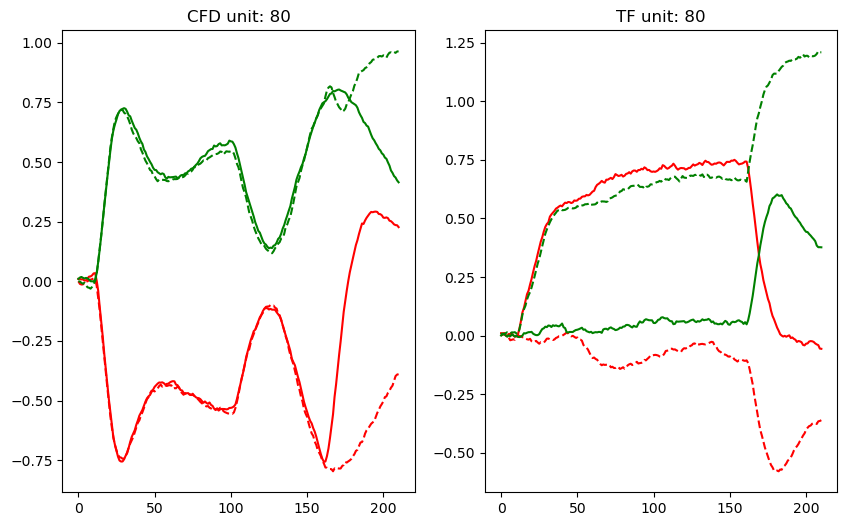

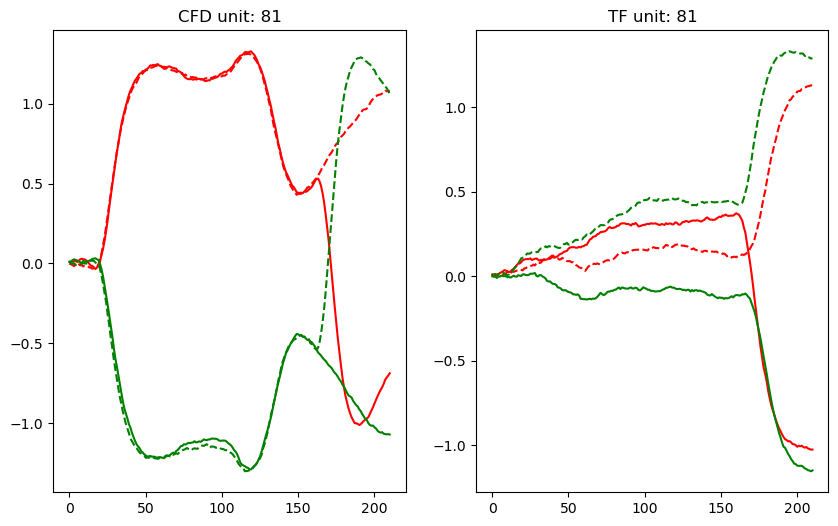

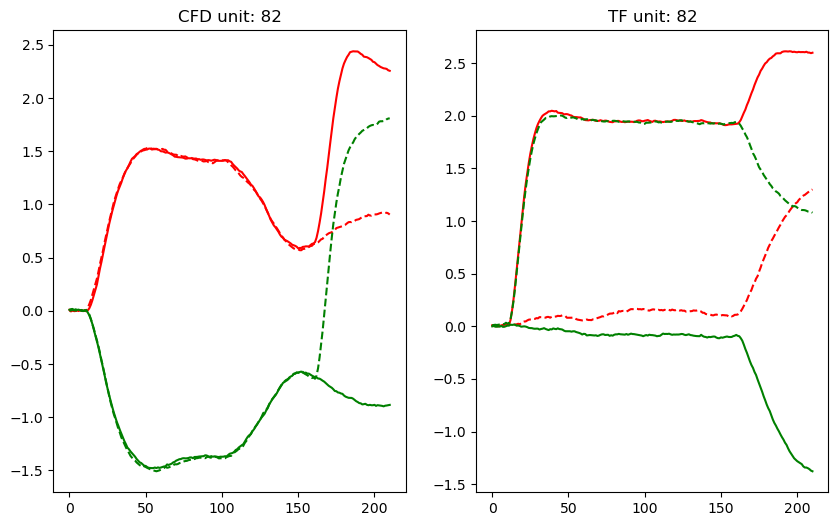

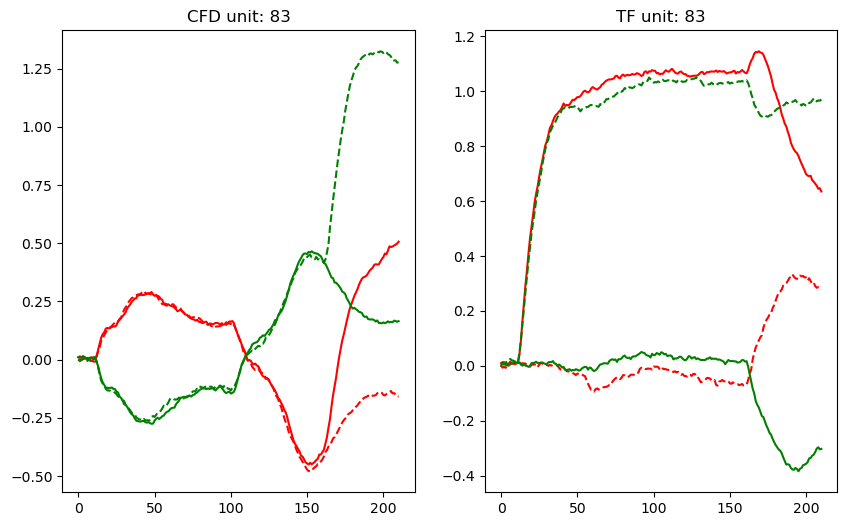

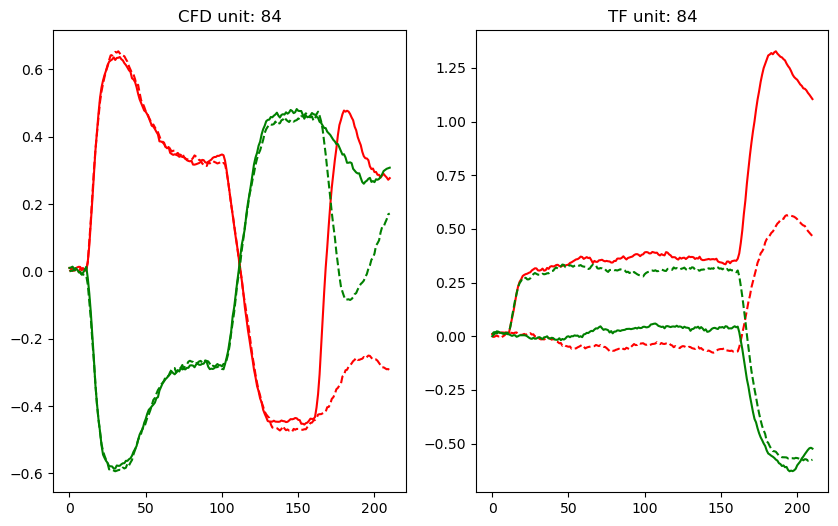

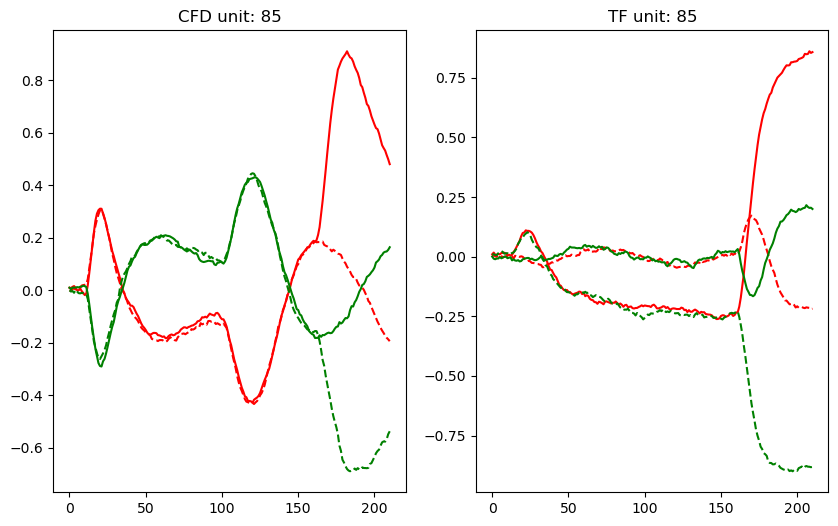

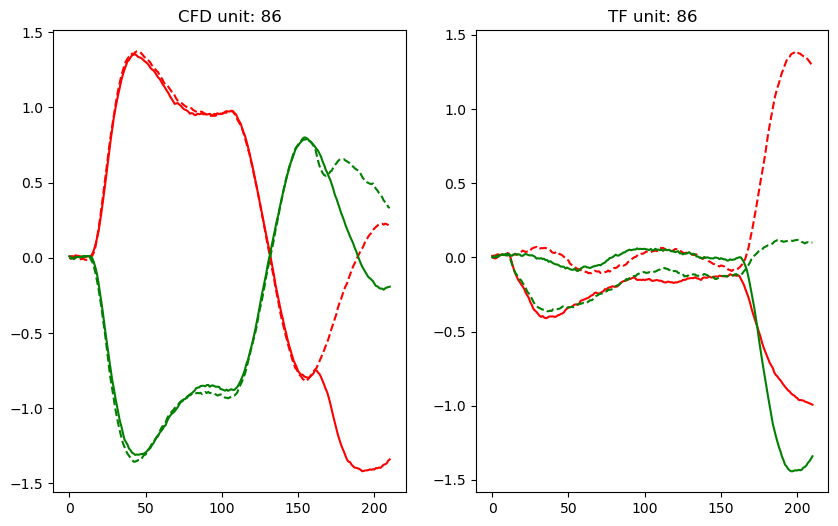

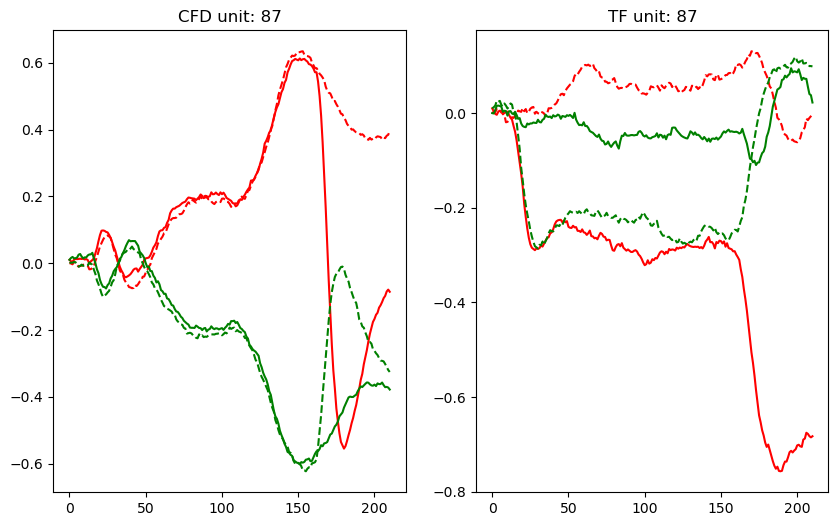

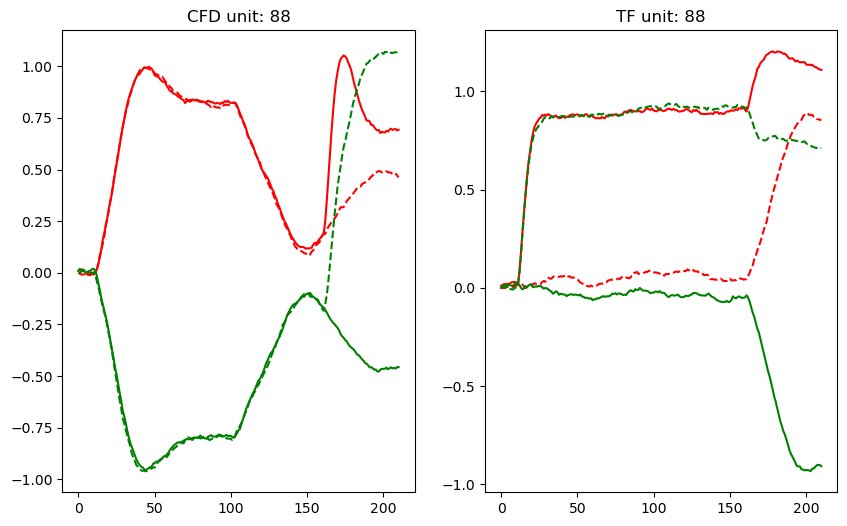

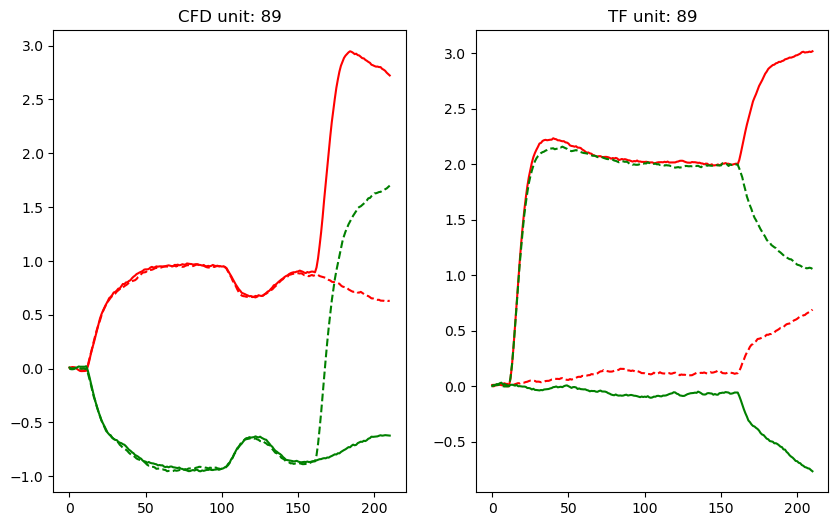

In [31]:
for n in range(80,90):
    plt.figure(figsize=(10,6))
    plt.subplot(121)
    plt.plot(np.mean(cfdRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(cfdRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(cfdGL,axis = 0)[:,n]+0.01, 'g-')
    plt.plot(np.mean(cfdGR,axis = 0)[:,n], 'g--')
    plt.title("CFD unit: " + str(n))
    
    plt.subplot(122)
    plt.plot(np.mean(tfRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n]+0.01, 'g--')
    plt.title("TF unit: " + str(n))

In [15]:
import scipy.io

traj = {
    'cfdTraj':cfdTraj,
    'tfTraj':tfTraj,
    'cfdDecision':cfdDecision,
    'cfdCoh':cfdCoh,
    'tfDecision':tfDecision,
    'tfCoh':tfCoh
}
filename = 'trajTotalSep.mat'
scipy.io.savemat(filename, traj)

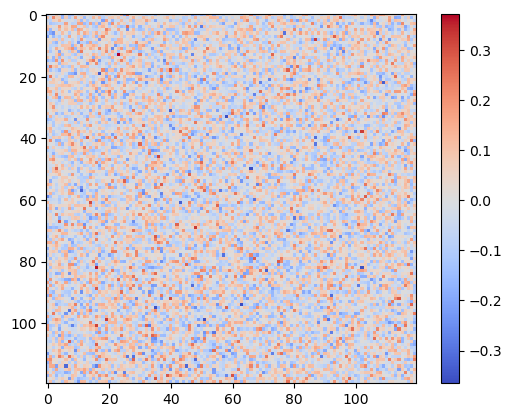

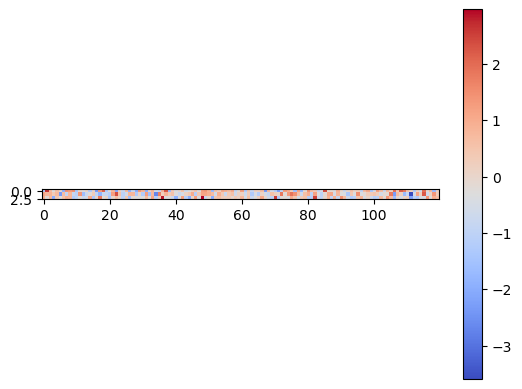

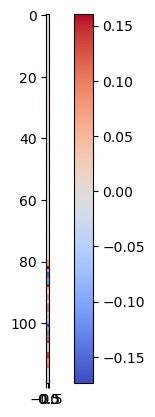

In [63]:
a = (net.wrec).detach().numpy()
plt.imshow(a)
plt.colorbar()
plt.set_cmap('coolwarm')
plt.show()

b = (net.wi).detach().numpy()
plt.imshow(b)
plt.colorbar()
plt.set_cmap('coolwarm')
plt.show()

c = (net.wo).detach().numpy()
plt.imshow(c)
plt.colorbar()
plt.set_cmap('coolwarm')
plt.show()


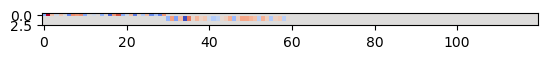

In [65]:
with torch.no_grad():
    net.wi.copy_(net.wi*wi_mask1)

    net.wo.copy_(net.wo*wo_mask1)
    net.wrec.copy_(net.wrec*wrec_mask1)

# save the model
# torch.save(net.state_dict(), f'../models/TFconn{size}.pt')

netwi = net.wi.detach().numpy()
netwo = net.wo.detach().numpy()
netwrec = net.wrec.detach().numpy()

plt.imshow(netwi)

In [17]:
# save the model
# torch.save(net.state_dict(), f'../models/CFDTFSeparateInput{size}.pt')

# train a low-rank RNN

loss=0.185, acc=1.000


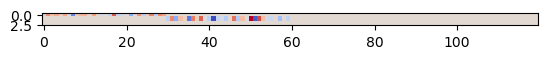

In [18]:
# load a full-rank RNN

net1 = FullRankRNN(3, size, 1, noise_std, alpha)
net1.load_state_dict(torch.load(f'../models/CFDTFSeparateInput{size}.pt', map_location='cpu'))

x_train, y_train, mask_train, cohAll_train, taskType_train, x_val, y_val, mask_val, cohAll_val, taskType_val = CFDTF.generate_checker_data(5000)

loss, acc, out, decisions, target_decisions, traj = CFDTF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')


# plot connectivity matrix 
net1wi = net1.wi.detach().numpy()
net1wo = net1.wo.detach().numpy()
plt.imshow(net1wi)



In [21]:
# define some parameters
# hidden_size: # units in low-rank RNN (should match that in full-rank RNN)
hidden_size = 120
rank = 4

In [22]:

# reduce the rank of connectivity matrix 
wi_init = net1.wi.detach()
wo_init = net1.wo.detach() * hidden_size
print(wo_init.std())
wrec = net1.wrec.detach().cpu().numpy()
u, s, v = np.linalg.svd(wrec)
m_init = torch.from_numpy(s[:rank] * u[:, :rank]).to(device=net1.wrec.device) * sqrt(hidden_size)
n_init = torch.from_numpy(v[:rank, :].transpose()).to(device=net1.wrec.device) * sqrt(hidden_size)
print(m_init.std())
print(n_init.std())

print(m_init.shape)
print(n_init.shape)

tensor(6.8382)
tensor(2.2578)
tensor(1.0003)
torch.Size([120, 4])
torch.Size([120, 4])


In [23]:
## train a 3-rank RNN

x_train, y_train, mask_train, cohAll_train, taskType_train, x_val, y_val, mask_val, cohAll_val, taskType_val = CFDTF.generate_checker_data(5000)

net_lo = LowRankRNN(3, size, 1, noise_std, alpha, rank=rank, wi_init=wi_init, wo_init=wo_init, m_init=m_init, n_init=n_init)

net_lo.non_linearity = torch.tanh
net_lo.out_non_linearity = torch.eye


train(net_lo, x_train, y_train, mask_train, n_epochs=20, lr=lr, batch_size=50, keep_best=True, cuda=True, clip_gradient=1, early_stop=0.2)
x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net_lo)


loss, acc, out, decisions, target_decisions, traj = CFDTF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

# # save the low-rank model
# torch.save(net_lo.state_dict(), "../models/CFDTF_rank3_1_{}.pt".format(hidden_size))


Training...
initial loss: 0.835
epoch 0:  loss=0.329  (took 10.11 s) *
epoch 1:  loss=0.255  (took 9.99 s) *
epoch 2:  loss=0.226  (took 10.12 s) *
epoch 3:  loss=0.213  (took 9.98 s) *
epoch 4:  loss=0.210  (took 9.87 s) *
epoch 5:  loss=0.207  (took 9.85 s) *
epoch 6:  loss=0.190  (took 9.81 s) *


NameError: name 'TF' is not defined

loss=0.179, acc=0.998


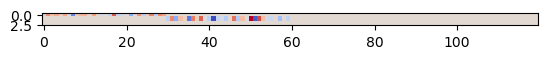

In [33]:
net1lowi = net_lo.wi.detach().numpy()
net1lowo = net_lo.wo.detach().numpy()
plt.imshow(net1lowi)

# plot psth

In [43]:
decisions1 = decisions.detach().numpy()
out1 = out.detach().numpy()
x_val1 = x_val.detach().numpy()

traj1 = traj.detach().numpy()


cfdDecision = decisions1[taskType_val == 1]
tfDecision = decisions1[taskType_val == 2]
cfdInputs = x_val1[taskType_val == 1]
tfInputs = x_val1[taskType_val == 2]
cfdOut = out1[taskType_val == 1]
tfOut = out1[taskType_val == 2]

cfdTraj = traj1[taskType_val == 1,:,:]
tfTraj = traj1[taskType_val == 2,:,:]

cfdCoh = cohAll_val[taskType_val == 1]
tfCoh = cohAll_val[taskType_val == 2]

cfdRL = cfdTraj[np.logical_and(cfdDecision == -1, cfdCoh > 0),:,:]
cfdRR = cfdTraj[np.logical_and(cfdDecision == 1, cfdCoh > 0),:,:]
cfdGL = cfdTraj[np.logical_and(cfdDecision == -1, cfdCoh < 0),:,:]
cfdGR = cfdTraj[np.logical_and(cfdDecision == 1, cfdCoh < 0),:,:]

tfRL = tfTraj[np.logical_and(tfDecision == -1, tfCoh > 0),:,:]
tfRR = tfTraj[np.logical_and(tfDecision == 1, tfCoh > 0),:,:]
tfGL = tfTraj[np.logical_and(tfDecision == -1, tfCoh < 0),:,:]
tfGR = tfTraj[np.logical_and(tfDecision == 1, tfCoh < 0),:,:]

In [47]:
# cfdTraj
# tfTraj
# cfdDecision
# cfdCoh
# tfDecision
# tfCoh

import scipy.io

traj = {
    'cfdTraj':cfdTraj,
    'tfTraj':tfTraj,
    'cfdDecision':cfdDecision,
    'cfdCoh':cfdCoh,
    'tfDecision':tfDecision,
    'tfCoh':tfCoh
}
filename = 'traj.mat'
scipy.io.savemat(filename, traj)

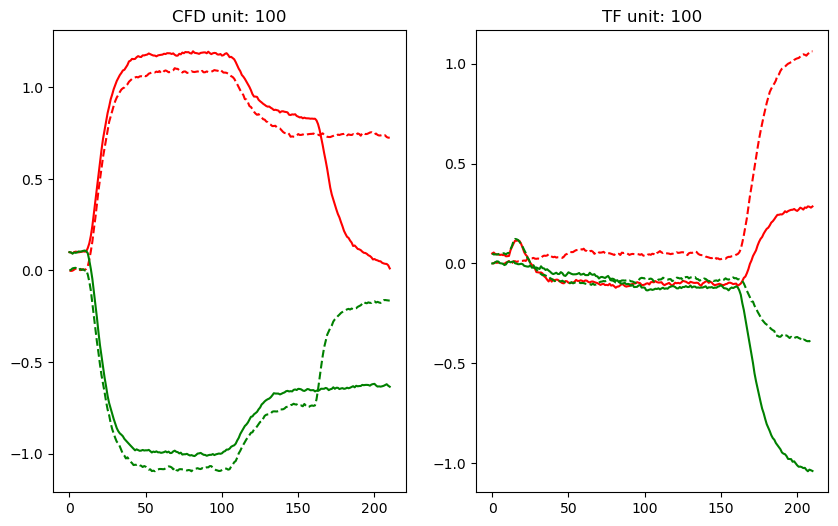

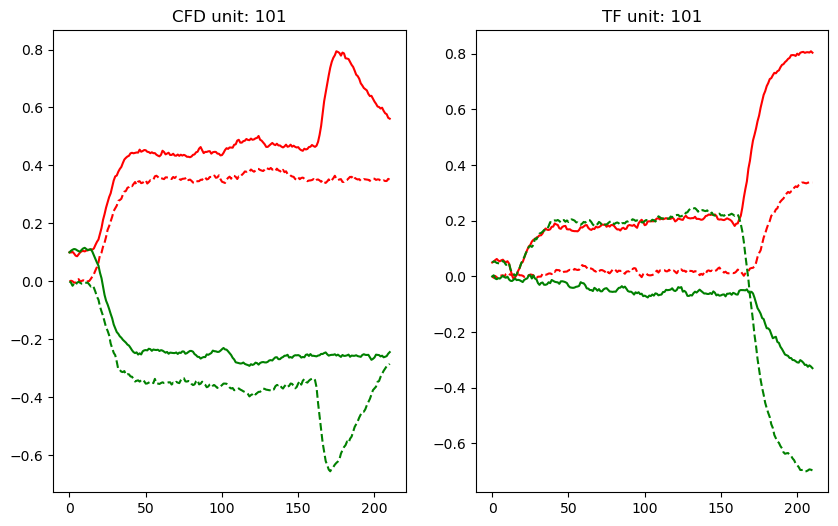

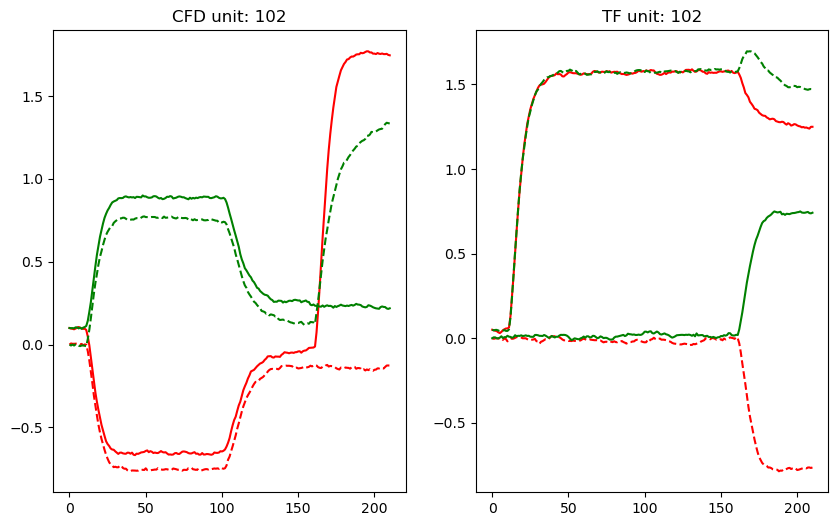

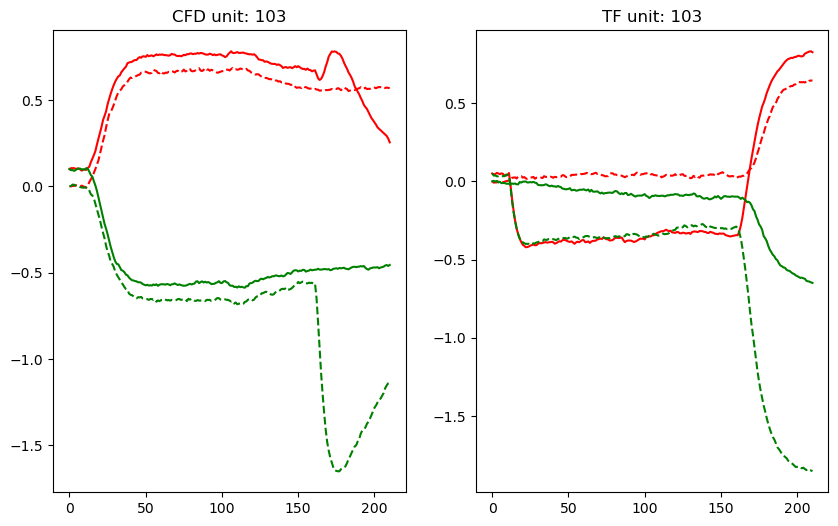

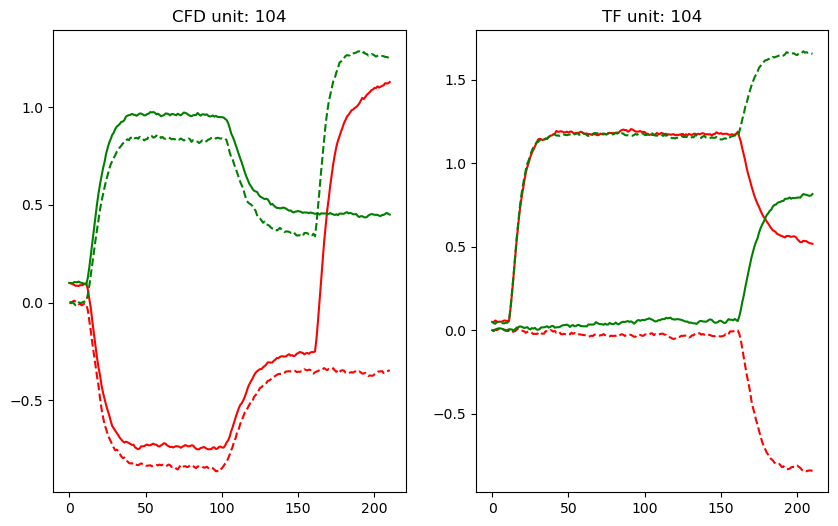

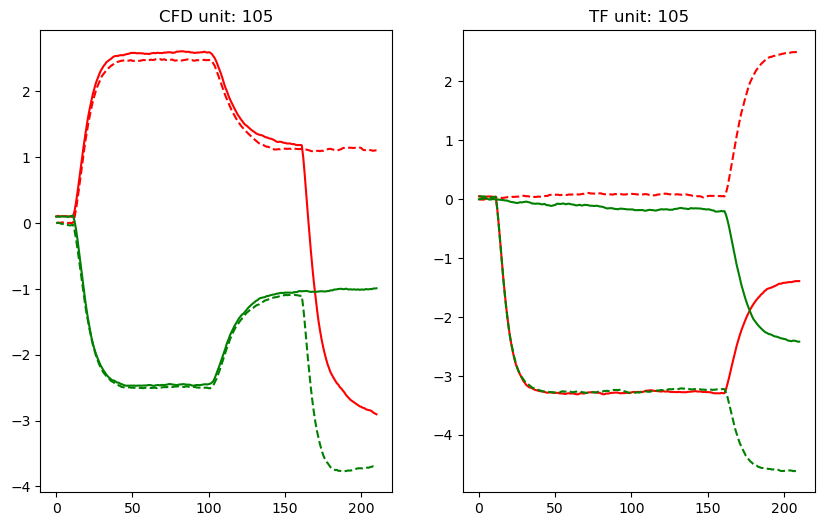

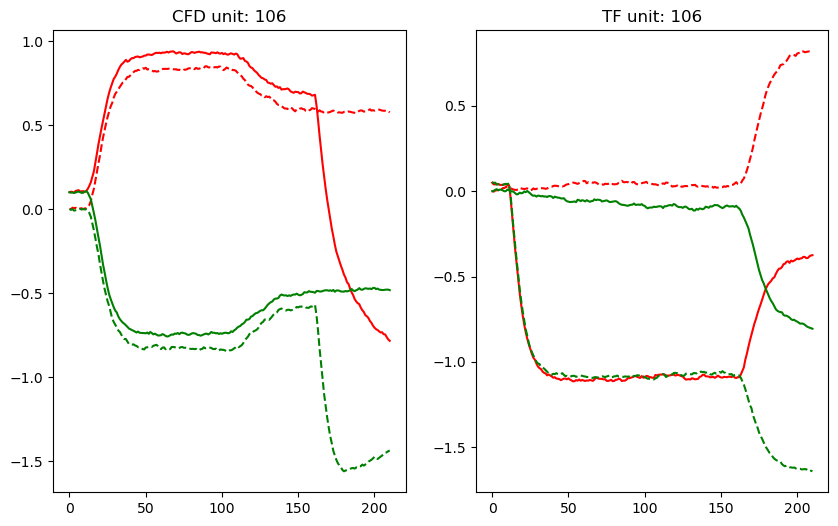

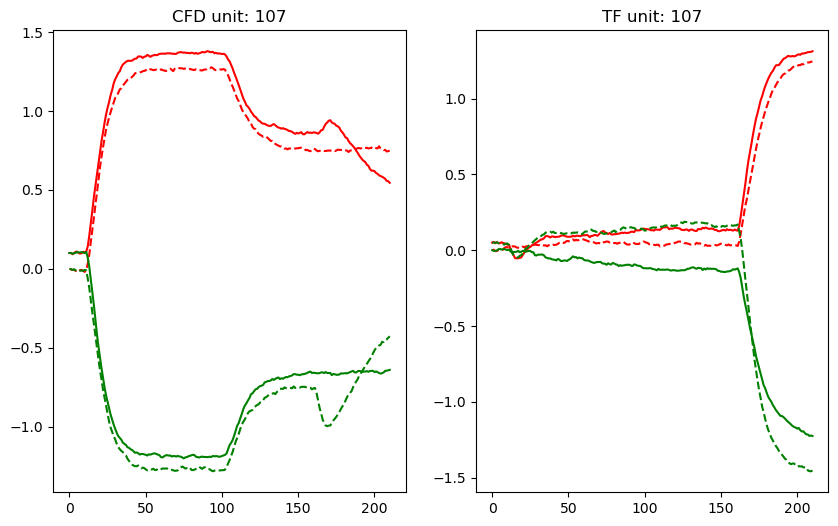

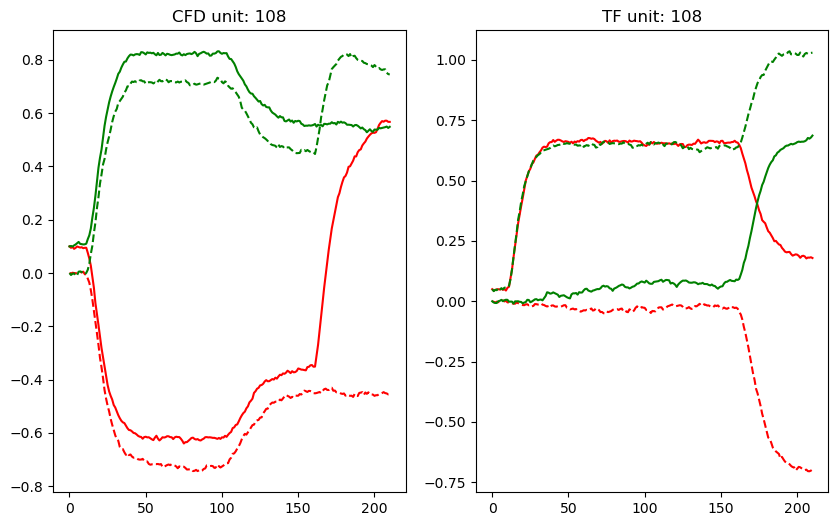

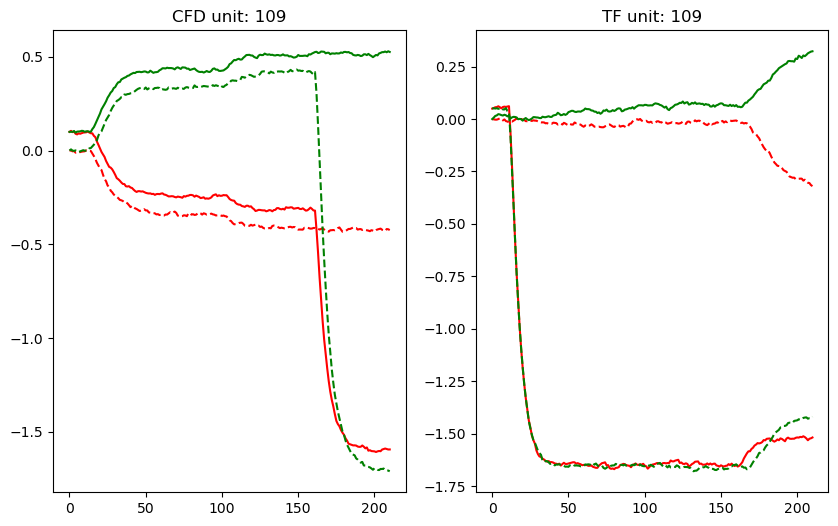

In [46]:
 
    
    plt.subplot(122)
    plt.plot(np.mean(tfRL,axis = 0)[:,n]+0.05, 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n]+0.05, 'g--')
    plt.title("TF unit: " + str(n))

In [35]:
# extract vectors
net_lo.svd_reparametrization()
wi1 = net_lo.wi[0].detach().numpy()
wi2 = net_lo.wi[1].detach().numpy()
wi3 = net_lo.wi[2].detach().numpy()
# n: low-rank Wrec connectivity vector n
n1 = net_lo.n[:, 0].detach().numpy()
n2 = net_lo.n[:, 1].detach().numpy()
n3 = net_lo.n[:, 2].detach().numpy()
# m: low-rank Wrec connectivity vector m
m1 = net_lo.m[:, 0].detach().numpy()
m2 = net_lo.m[:, 1].detach().numpy()
m3 = net_lo.m[:, 2].detach().numpy()
wo = net_lo.wo.detach().squeeze().numpy()

In [36]:
# generate trajLow

CFDtrajLow = np.zeros((4, cfdRL.shape[1], cfdRL.shape[2]))
CFDtrajLow[0,:,:] = np.mean(cfdRL,axis = 0)
CFDtrajLow[1,:,:] =np.mean(cfdRR,axis = 0)
CFDtrajLow[2,:,:] =np.mean(cfdGL,axis = 0)
CFDtrajLow[3,:,:] =np.mean(cfdGR,axis = 0)

TFtrajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
TFtrajLow[0,:,:] = np.mean(tfRL,axis = 0)
TFtrajLow[1,:,:] =np.mean(tfRR,axis = 0)
TFtrajLow[2,:,:] =np.mean(tfGL,axis = 0)
TFtrajLow[3,:,:] =np.mean(tfGR,axis = 0)

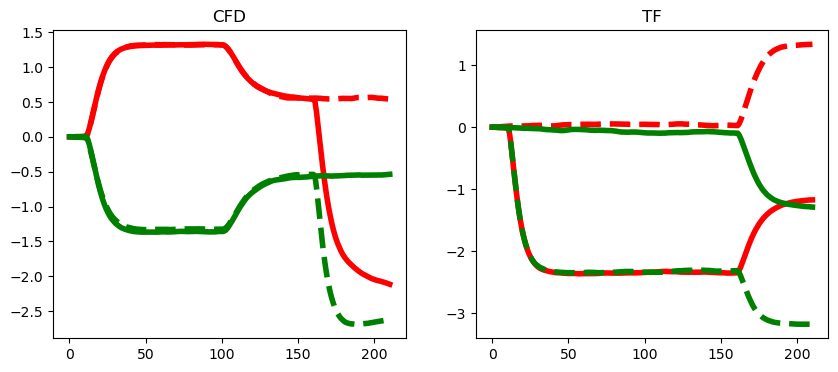

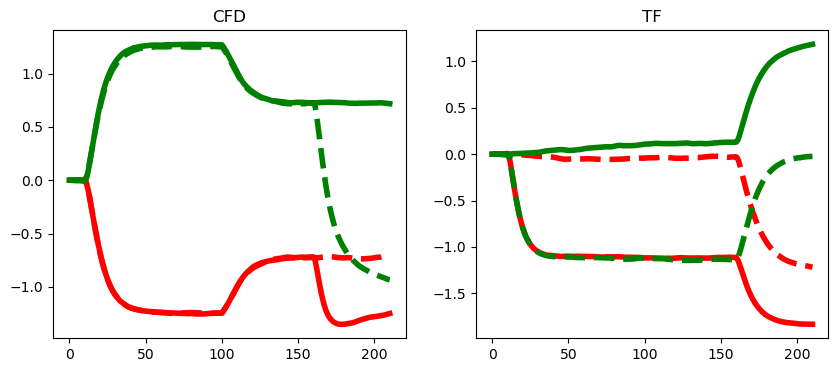

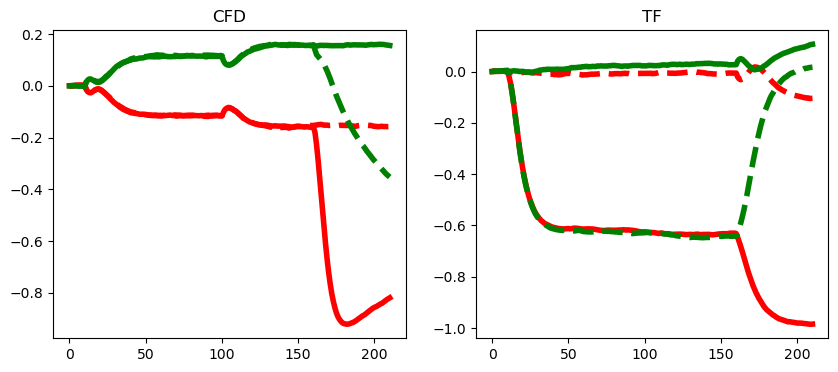

In [37]:
# project low rank rnn trajs, both cfd and tf) on m vectors


# project low rank rnn traj on m1 vector
CFDkap1 = CFDtrajLow @ m1 / size
CFDkap2 = CFDtrajLow @ m2 / size
CFDkap3 = CFDtrajLow @ m3 / size

TFkap1 = TFtrajLow @ m1 / size
TFkap2 = TFtrajLow @ m2 / size
TFkap3 = TFtrajLow @ m3 / size

colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']

plt.figure(figsize=(10,4))
for i in range(4):
    plt.subplot(121)
    plt.plot(CFDkap1[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.title("CFD")

    plt.subplot(122)
    plt.plot(TFkap1[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.title("TF")
plt.show()

plt.figure(figsize=(10,4))
for i in range(4):
    plt.subplot(121)
    plt.plot(CFDkap2[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.title("CFD")

    plt.subplot(122)
    plt.plot(TFkap2[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.title("TF")
plt.show()

plt.figure(figsize=(10,4))
for i in range(4):
    plt.subplot(121)
    plt.plot(CFDkap3[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.title("CFD")

    plt.subplot(122)
    plt.plot(TFkap3[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.title("TF")
plt.show()



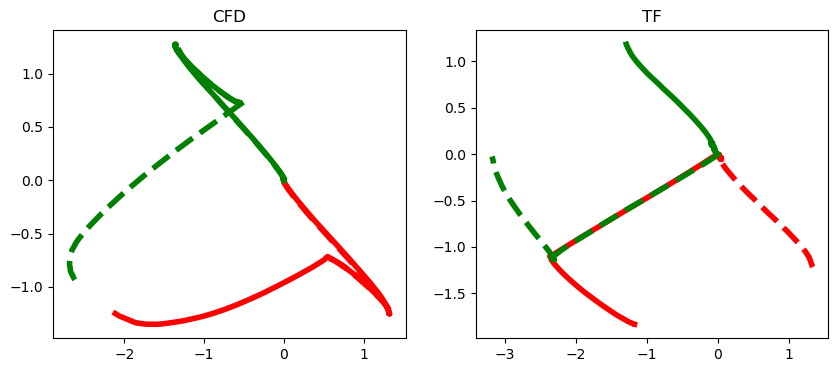

In [38]:
plt.figure(figsize=(10,4))
for i in range(4):
    plt.subplot(121)
    plt.plot(CFDkap1[i], CFDkap2[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.title("CFD")

    plt.subplot(122)
    plt.plot(TFkap1[i], TFkap2[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.title("TF")
    
plt.show()



(844, 120)


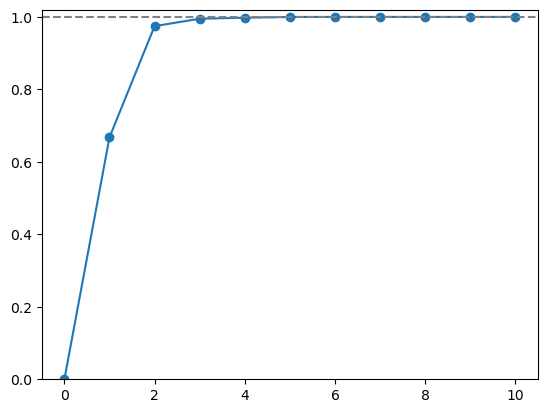

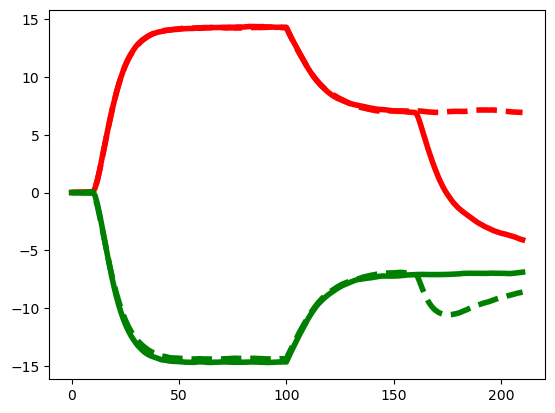

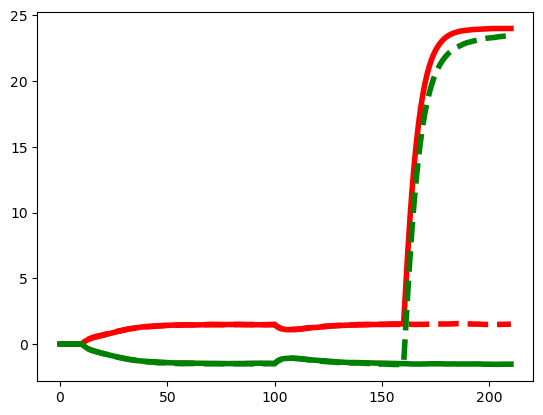

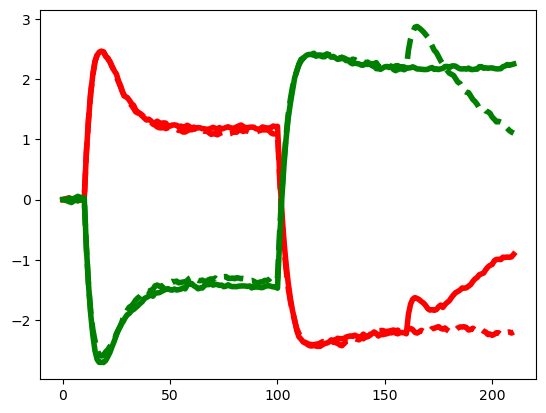

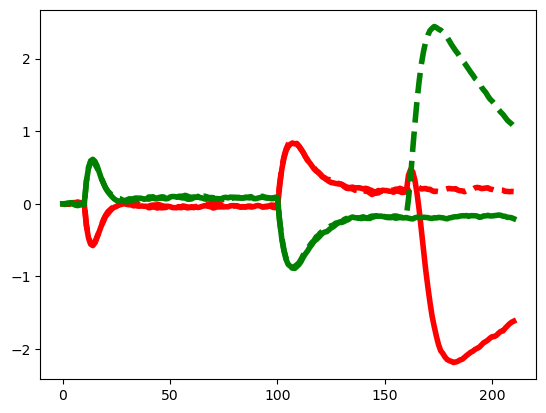

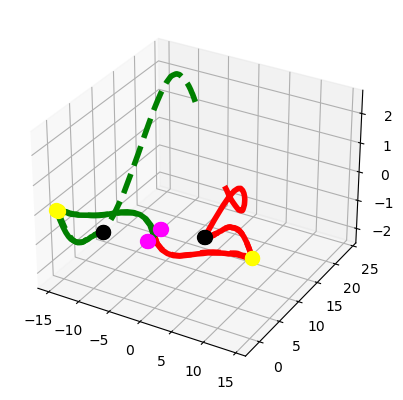

In [39]:
# CFD pca
COn = 10
COff = 100
TOn = 160

# low rank RNN pca
pca = plot.pca_cumvar(CFDtrajLow, n_components=10)
plt.ylim(0, 1.02)
plt.axhline(1, ls='--', c='gray')
plt.show()

labels = ['RL', 'RR', 'GL', 'GR']

ax1 = pca.components_[0]
ax2 = pca.components_[1]
ax3 = pca.components_[2]
ax4 = pca.components_[3]

k1 = CFDtrajLow @ ax1
k2 = CFDtrajLow @ ax2
k3 = CFDtrajLow @ ax3
k4 = CFDtrajLow @ ax4

plt.figure()
for i in range(4):
    plt.plot(k1[i], c=colors[i], lw=4, ls = lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k2[i], c=colors[i], lw=4, ls = lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i])
plt.show()

# 3D pca plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    plt.plot(k1[i], k2[i], k4[i], c=colors[i], lw=4, ls = lineStyle[i])
    ax.scatter(k1[i, COn], k2[i, TOn], k4[i, COn], c='magenta',
            marker='.', s=400)
    ax.scatter(k1[i, COff], k2[i, COff], k4[i, COff], c= 'yellow',
            marker='.', s=400)
    ax.scatter(k1[i, TOn], k2[i, TOn], k4[i, TOn], c= 'black',
            marker='.', s=400)

# ax.view_init(elev=38, azim=90)
plt.show()

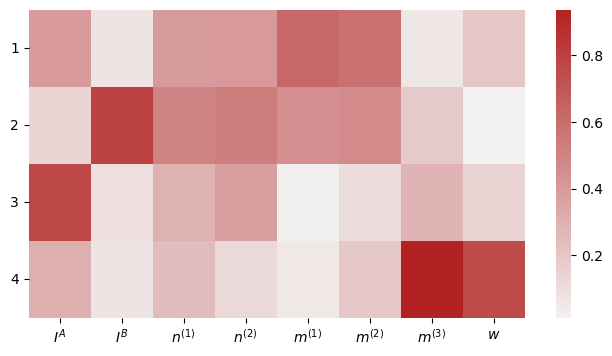

In [40]:
# m1: color; m2: color / dir; m3: context
# ax1 / ax4: color; ax2 / ax3: context
vecs_pca = [ax1, ax2, ax3, ax4]
vecs_fit = [wi1, wi2, n1, n2, m1, m2, m3, wo]

helpers.overlap_matrix2(vecs_pca, vecs_fit, norm='l2', figsize=(8,4), abs=True, cmap='abs')
# plt.xlabel('Fitted connectivity')
# plt.ylabel('TDR axes')
plt.xticks(np.arange(0.5, 8, 1), ['$I^A$', '$I^B$', '$n^{(1)}$', '$n^{(2)}$', '$m^{(1)}$', '$m^{(2)}$', '$m^{(3)}$', '$w$'])
plt.yticks(np.arange(0.5, 4, 1), ['1', '2', '3', '4'], rotation='horizontal')
plt.show()

(844, 120)


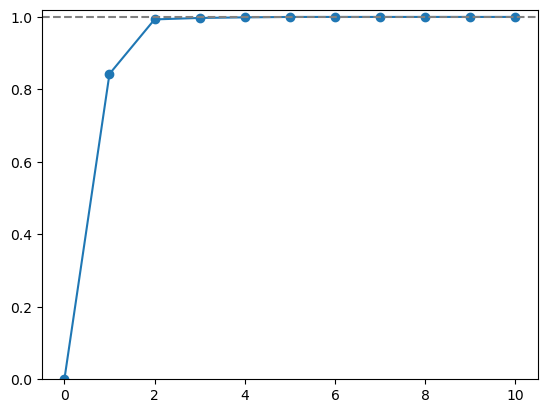

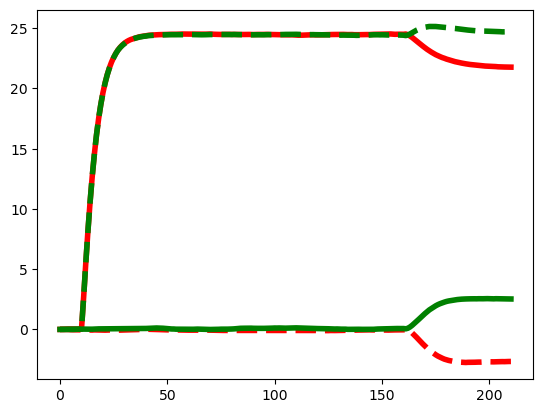

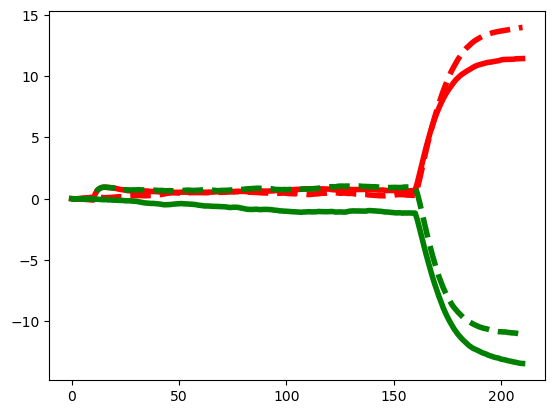

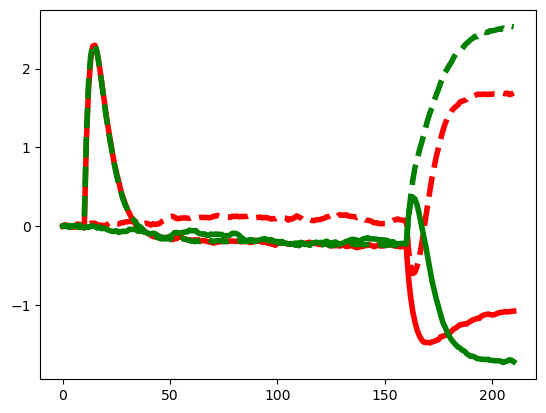

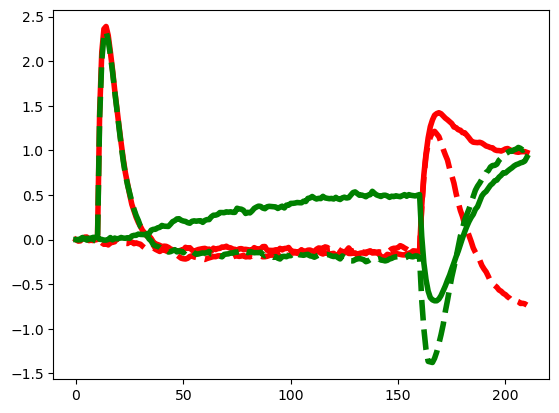

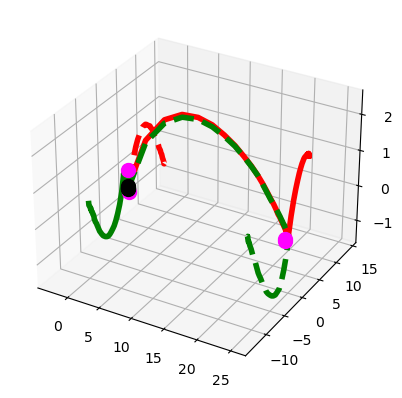

In [41]:
# TF pca
COn = 160
TOn = 10

# low rank RNN pca
pca = plot.pca_cumvar(TFtrajLow, n_components=10)
plt.ylim(0, 1.02)
plt.axhline(1, ls='--', c='gray')
plt.show()

labels = ['RL', 'RR', 'GL', 'GR']

ax1 = pca.components_[0]
ax2 = pca.components_[1]
ax3 = pca.components_[2]
ax4 = pca.components_[3]

k1 = TFtrajLow @ ax1
k2 = TFtrajLow @ ax2
k3 = TFtrajLow @ ax3
k4 = TFtrajLow @ ax4

plt.figure()
for i in range(4):
    plt.plot(k1[i], c=colors[i], lw=4, ls = lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k2[i], c=colors[i], lw=4, ls = lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i])
plt.show()

# 3D pca plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    plt.plot(k1[i], k2[i], k4[i], c=colors[i], lw=4, ls = lineStyle[i])
    ax.scatter(k1[i, COn], k2[i, TOn], k4[i, COn], c='magenta',
            marker='.', s=400)
    ax.scatter(k1[i, TOn], k2[i, TOn], k4[i, TOn], c= 'black',
            marker='.', s=400)

# ax.view_init(elev=38, azim=90)
plt.show()

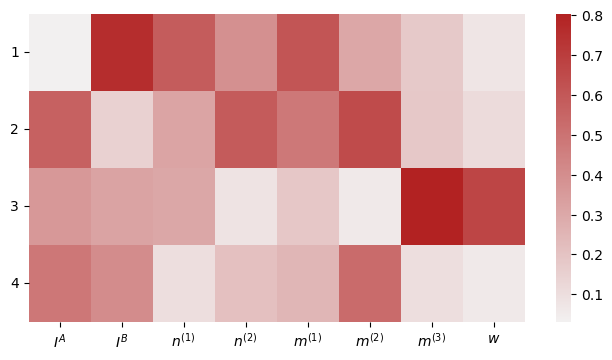

In [42]:
# m1: color; m2: context / dir; m3: context
# ax1: context; ax2: color; ax4: dir

vecs_pca = [ax1, ax2, ax3, ax4]
vecs_fit = [wi1, wi2, n1, n2, m1, m2, m3, wo]

helpers.overlap_matrix2(vecs_pca, vecs_fit, norm='l2', figsize=(8,4), abs=True, cmap='abs')
# plt.xlabel('Fitted connectivity')
# plt.ylabel('TDR axes')
plt.xticks(np.arange(0.5, 8, 1), ['$I^A$', '$I^B$', '$n^{(1)}$', '$n^{(2)}$', '$m^{(1)}$', '$m^{(2)}$', '$m^{(3)}$','$w$'])
plt.yticks(np.arange(0.5, 4, 1), ['1', '2', '3', '4'], rotation='horizontal')
plt.show()

# field

In [1]:
COn = 10
COff = 100
TOn = 160
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m1, m3, -3, 3, -1, 1)
for i in range(4):
    plt.plot(CFDkap1[i], CFDkap3[i], c=colors[i], lw=2, ls=lineStyle[i])
    plt.scatter(CFDkap1[i, COn], CFDkap3[i, COn], c='magenta',
            marker='.', s=400)
    plt.scatter(CFDkap1[i, COff], CFDkap3[i, COff], c= 'yellow',
            marker='.', s=400)
    plt.scatter(CFDkap1[i, TOn], CFDkap3[i, TOn], c= 'black',
            marker='.', s=400)      

NameError: name 'plt' is not defined

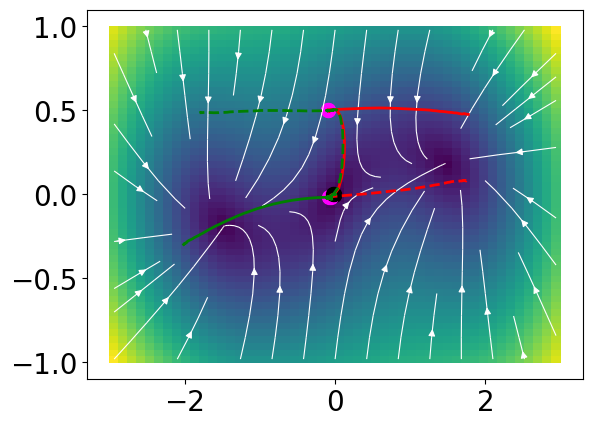

In [25]:
# TF
COn = 160
TOn = 10
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m1, m3, -3, 3, -1, 1)
for i in range(4):
    plt.plot(TFkap1[i], TFkap3[i], c=colors[i], lw=2, ls=lineStyle[i])
    plt.scatter(TFkap1[i, COn], TFkap3[i, COn], c='magenta',
            marker='.', s=400)
    plt.scatter(TFkap1[i, TOn], TFkap3[i, TOn], c= 'black',
            marker='.', s=400)  